# Forecasting Potential Video Game Sales

**Dataset:** [Kaggle · Video Game Sales](https://www.kaggle.com/datasets/gregorut/videogamesales)

## 1. Project Topic & Goals
- **Problem Type:** Supervised regresion - predict global sales for video game releases.
- **Motivation:** Support publishers and retailers with demand forecasting, inventory planning, and marketing focus.
- **Learning Objectives:**
  - Explore how platform mix, genre, publisher footprint, and release timing relate to sales performance.
  - Compare baseline, linear, and ensemble regression models built on regional sales signals and metadata.

## 2. Notebook Roadmap
1. Data source citation & description
2. Data quality checks and cleaning
3. Exploratory data analysis (EDA)
4. Feature engineering & preprocessing
5. Modeling and evaluation
6. Results discussion & conclusions
7. Next steps & repository pointers

In [20]:
# 2.1 Environment & Imports
import warnings
warnings.filterwarnings('ignore')

import math
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 3. Data Source & Provenance
- **Original Source:** Gregory Smith, aggregated from VGChartz. Accessible via Kaggle dataset `gregorut/videogamesales`.
- **License:** Creative Commons Attribution-ShareAlike 4.0 (per Kaggle page). Verify license updates before public distribution.
- **Download Instructions:** Place `vgsales.csv` in the `data/` directory relative to this notebook. Kaggle CLI example:
  ```bash
  kaggle datasets download -d gregorut/videogamesales -p data/ --unzip
  ```

In [21]:
# 3.1 Load Data
DATA_DIR = Path('../data').resolve()
CSV_PATH = DATA_DIR / 'vgsales.csv'

if not CSV_PATH.exists():
    kaggle_path = Path('/kaggle/input/videogamesales/vgsales.csv')
    if kaggle_path.exists():
        CSV_PATH = kaggle_path
    else:
        raise FileNotFoundError(
            f"Dataset not found at {CSV_PATH}. Please download from Kaggle and place it in ../data/."
        )

raw_df = pd.read_csv(CSV_PATH)
raw_df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


## 4. Dataset Summary
Summaries capture shape, feature types, missingness, and basic statistics so we can plan cleaning/EDA.

In [22]:
# 4.1 Shape & column overview
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [23]:
# 4.2 Missing value counts and basic descriptive statistics
missing_counts = raw_df.isna().sum().sort_values(ascending=False)
describe_numeric = raw_df.describe(include=[np.number]).T

missing_counts, describe_numeric

(Year            271
 Publisher        58
 Rank              0
 Platform          0
 Name              0
 Genre             0
 NA_Sales          0
 EU_Sales          0
 JP_Sales          0
 Other_Sales       0
 Global_Sales      0
 dtype: int64,
                 count         mean          std      min      25%      50%  \
 Rank          16598.0  8300.605254  4791.853933     1.00  4151.25  8300.50   
 Year          16327.0  2006.406443     5.828981  1980.00  2003.00  2007.00   
 NA_Sales      16598.0     0.264667     0.816683     0.00     0.00     0.08   
 EU_Sales      16598.0     0.146652     0.505351     0.00     0.00     0.02   
 JP_Sales      16598.0     0.077782     0.309291     0.00     0.00     0.00   
 Other_Sales   16598.0     0.048063     0.188588     0.00     0.00     0.01   
 Global_Sales  16598.0     0.537441     1.555028     0.01     0.06     0.17   
 
                    75%       max  
 Rank          12449.75  16600.00  
 Year           2010.00   2020.00  
 NA_Sales   

In [24]:
# 4.3 Peek at categorical cardinalities
categorical_cols = ["Name", "Platform", "Year_of_Release", "Genre", "Publisher"]
for col in categorical_cols:
    if col in raw_df.columns:
        unique_vals = raw_df[col].nunique(dropna=True)
        print(f"{col}: {unique_vals} unique values")

Name: 11493 unique values
Platform: 31 unique values
Genre: 12 unique values
Publisher: 578 unique values


## 5. Data Cleaning Strategy
- Handle missing `year` or `publisher` entries (e.g., impute, flag, or bucket as `Unknown`) and document choices.
- Standardize column names, derive release decade, and compute helper features such as publisher frequency counts.
- Check for duplicates/outliers, summarize cleaning decisions, and note any limitations impacting downstream analysis.

In [25]:
# 5.1 Helper transforms

def clean_vgsales(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Standardize column names
    df.columns = [c.lower() for c in df.columns]
    # Convert user_score to numeric (dataset stores text with possible 'tbd')
    if 'user_score' in df.columns:
        df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')
    # Rename year column for clarity
    if 'year_of_release' in df.columns:
        df.rename(columns={'year_of_release': 'year'}, inplace=True)
    # Create release decade feature
    if 'year' in df.columns:
        df['year'] = pd.to_numeric(df['year'], errors='coerce')
        df['release_decade'] = (df['year'] // 10 * 10).astype('Int64')
    # Frequency encode publisher for modeling convenience
    if 'publisher' in df.columns:
        publisher_counts = df['publisher'].value_counts()
        df['publisher_freq'] = df['publisher'].map(publisher_counts)
    return df

clean_df = clean_vgsales(raw_df)
clean_df.head()

,rank,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,release_decade,publisher_freq
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,2000,703.0
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,1980,703.0
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,2000,703.0
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,2000,703.0
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,1990,703.0


In [26]:
# 5.2 Re-check missingness post-cleaning
clean_missing = clean_df.isna().sum().sort_values(ascending=False)
clean_missing

year              271
release_decade    271
publisher          58
publisher_freq     58
rank                0
genre               0
platform            0
name                0
na_sales            0
jp_sales            0
eu_sales            0
global_sales        0
other_sales         0
dtype: int64

## 6. Exploratory Data Analysis (EDA)
Focus on understanding sales distribution, platform/genre trends, release timing, and regional sales relationships.

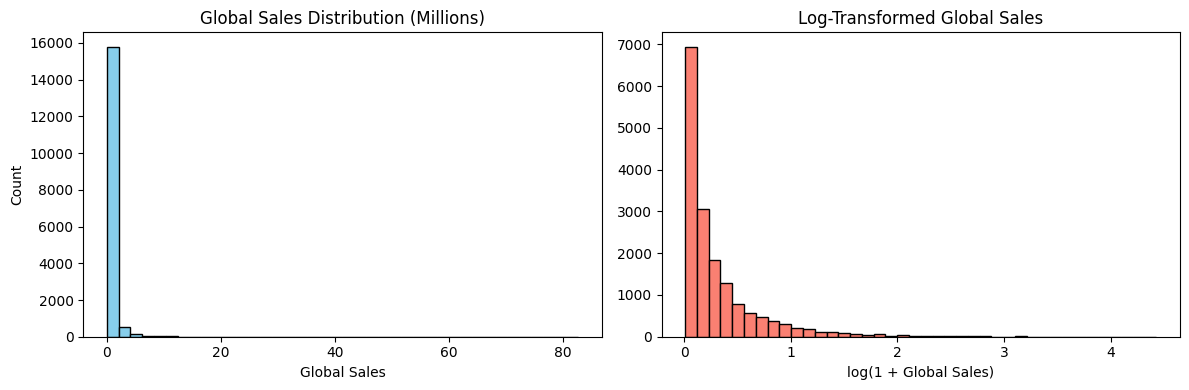

In [27]:
# 6.1 Target distribution (log-scale to handle heavy tail)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(clean_df['global_sales'], bins=40, color='skyblue', edgecolor='black')
ax[0].set_title('Global Sales Distribution (Millions)')
ax[0].set_xlabel('Global Sales')
ax[0].set_ylabel('Count')

log_sales = np.log1p(clean_df['global_sales'])
ax[1].hist(log_sales, bins=40, color='salmon', edgecolor='black')
ax[1].set_title('Log-Transformed Global Sales')
ax[1].set_xlabel('log(1 + Global Sales)')
plt.tight_layout()
plt.show()

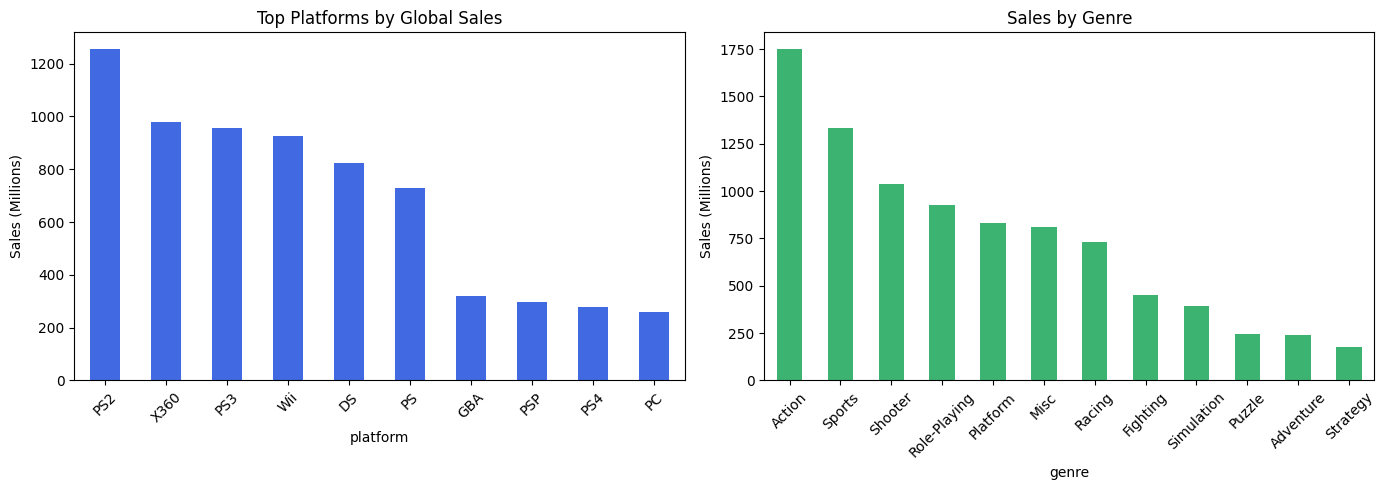

In [28]:
# 6.2 Sales by platform and genre
platform_sales = clean_df.groupby('platform')['global_sales'].sum().sort_values(ascending=False).head(10)
genre_sales = clean_df.groupby('genre')['global_sales'].sum().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14,5))
platform_sales.plot(kind='bar', ax=axes[0], color='royalblue')
axes[0].set_title('Top Platforms by Global Sales')
axes[0].set_ylabel('Sales (Millions)')
axes[0].tick_params(axis='x', rotation=45)

genre_sales.plot(kind='bar', ax=axes[1], color='mediumseagreen')
axes[1].set_title('Sales by Genre')
axes[1].set_ylabel('Sales (Millions)')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

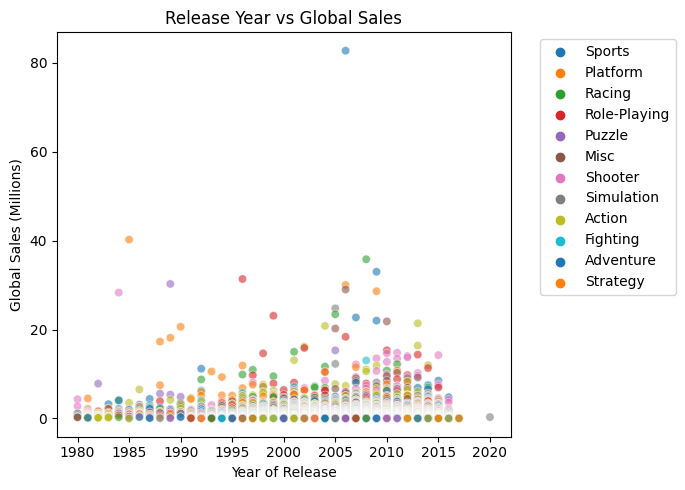

In [29]:
# 6.3 Release year vs sales
year_scatter = clean_df.dropna(subset=['year'])
fig, ax = plt.subplots(figsize=(7,5))
sns.scatterplot(data=year_scatter, x='year', y='global_sales', hue='genre', alpha=0.6, palette='tab10')
ax.set_title('Release Year vs Global Sales')
ax.set_xlabel('Year of Release')
ax.set_ylabel('Global Sales (Millions)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

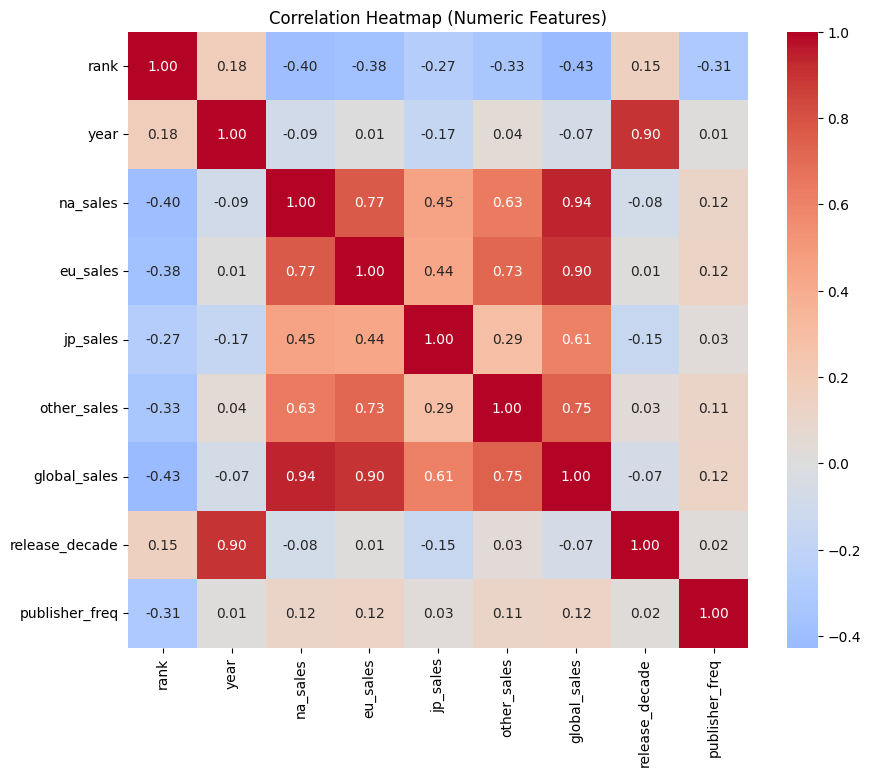

In [30]:
# 6.4 Correlation heatmap for numeric features
numeric_cols = clean_df.select_dtypes(include=[np.number]).columns
corr = clean_df[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

## 6. Exploratory Data Analysis (EDA)
- Global sales distribution is extremely right-skewed: the log transform reveals a long tail of blockbusters (few titles) driving revenue while most games sell fewer than 1M units.
- Nintendo-heavy platforms (Wii, DS, 3DS) and Sony's PS2/PS3 dominate cumulative sales; genres led by Action, Sports, and Shooter titles.
- Release activity peaked between 2005–2010; sales taper for more recent years as dataset coverage declines.
- Publisher frequency highlights a power-law pattern: a handful of mega-publishers (Nintendo, EA, Activision, Ubisoft) account for most releases and revenue.

## 7. Feature Engineering & Modeling Pipeline
- Target variable: `global_sales` (millions of units).
- Features retained: categorical (`platform`, `genre`, `publisher`) and temporal/publisher signals (`release_decade`, `year`, `publisher_freq`).
- Preprocessing: impute missing numerics (median), scale numeric features, and one-hot encode categoricals with dense output for tree models.
- Models evaluated: baseline mean, LinearRegression, Ridge, Lasso, RandomForest, HistGradientBoosting.
- Metrics: MAE, RMSE, R² on train/test splits; GridSearchCV (3-fold) for tree models with reduced grids for faster iteration.

In [31]:
# 7.1 Train/test split
FEATURES = [
    'platform', 'genre', 'publisher', 'release_decade', 'year', 'publisher_freq'
]
TARGET = 'global_sales'

model_df = clean_df.dropna(subset=[TARGET]).copy()
X = model_df[FEATURES]
y = model_df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((13278, 6), (3320, 6))

In [32]:
# 7.2 Preprocessing pipeline (outputs dense arrays for tree models)
numeric_features = [
    'release_decade', 'year', 'publisher_freq'
]
categorical_features = ['platform', 'genre', 'publisher']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    sparse_threshold=0.0
)

In [33]:
# 7.3 Baseline model
baseline_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', DummyRegressor(strategy='mean'))
])

baseline_model.fit(X_train, y_train)

def evaluate(model, X_train, y_train, X_test, y_test, name="model"):
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)
    metrics = {
        'model': name,
        'mae_train': mean_absolute_error(y_train, preds_train),
        'mae_test': mean_absolute_error(y_test, preds_test),
        'rmse_train': mean_squared_error(y_train, preds_train, squared=False),
        'rmse_test': mean_squared_error(y_test, preds_test, squared=False),
        'r2_train': r2_score(y_train, preds_train),
        'r2_test': r2_score(y_test, preds_test)
    }
    return metrics

results = []
results.append(evaluate(baseline_model, X_train, y_train, X_test, y_test, name='DummyRegressor'))
results

[{'model': 'DummyRegressor',
  'mae_train': 0.5780573757505759,
  'mae_test': 0.6174564366821103,
  'rmse_train': 1.404160975941715,
  'rmse_test': 2.0501881554636774,
  'r2_train': 0.0,
  'r2_test': -0.00045401835363212406}]

In [34]:
# 7.4 Linear regression family
linear_models = {
    'LinearRegression': LinearRegression(),
    "Ridge(alpha=10, solver='lsqr')": Ridge(alpha=10, solver='lsqr'),
    'Lasso(alpha=0.001)': Lasso(alpha=0.001, max_iter=5000)
}

for name, estimator in linear_models.items():
    model = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', estimator)
    ])
    model.fit(X_train, y_train)
    results.append(evaluate(model, X_train, y_train, X_test, y_test, name=name))

results

[{'model': 'DummyRegressor',
  'mae_train': 0.5780573757505759,
  'mae_test': 0.6174564366821103,
  'rmse_train': 1.404160975941715,
  'rmse_test': 2.0501881554636774,
  'r2_train': 0.0,
  'r2_test': -0.00045401835363212406},
 {'model': 'LinearRegression',
  'mae_train': 0.5054038802657003,
  'mae_test': 490685725.7673865,
  'rmse_train': 1.2865225369943782,
  'rmse_test': 11882877800.897326,
  'r2_train': 0.16053808284202997,
  'r2_test': -3.360879600591955e+19},
 {'model': "Ridge(alpha=10, solver='lsqr')",
  'mae_train': 0.5068258592800704,
  'mae_test': 0.5534324961624314,
  'rmse_train': 1.2890356996674877,
  'rmse_test': 1.955218803278697,
  'r2_train': 0.15725517888933072,
  'r2_test': 0.09008584113994511},
 {'model': 'Lasso(alpha=0.001)',
  'mae_train': 0.5061682507455098,
  'mae_test': 0.5507566639240996,
  'rmse_train': 1.2931343858397026,
  'rmse_test': 1.9564854483938634,
  'r2_train': 0.15188738645422628,
  'r2_test': 0.08890652387294995}]

In [35]:
# 7.5 Tree-based models with lightweight hyperparameter grids (faster for iteration)
print('Fitting RandomForest grid (2 parameter combos × 3 CV folds = 6 fits) ...')
forest_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE))
])

forest_param_grid = {
    'model__n_estimators': [200],
    'model__max_depth': [None, 20],
    'model__min_samples_split': [2]
}

forest_grid = GridSearchCV(
    forest_pipeline,
    param_grid=forest_param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    verbose=2
)
forest_grid.fit(X_train, y_train)
results.append(
    evaluate(
        forest_grid.best_estimator_, X_train, y_train, X_test, y_test,
        name='RandomForest(best)'
    )
)

print('Fitting HistGradientBoosting grid (2 parameter combos × 3 CV folds = 6 fits) ...')
hgb_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', HistGradientBoostingRegressor(random_state=RANDOM_STATE))
])

hgb_param_grid = {
    'model__max_depth': [None],
    'model__learning_rate': [0.05, 0.1],
    'model__l2_regularization': [0.0]
}

hgb_grid = GridSearchCV(
    hgb_pipeline,
    param_grid=hgb_param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    verbose=2
)
hgb_grid.fit(X_train, y_train)
results.append(
    evaluate(
        hgb_grid.best_estimator_, X_train, y_train, X_test, y_test,
        name='HistGradientBoosting(best)'
    )
)

Fitting RandomForest grid (2 parameter combos × 3 CV folds = 6 fits) ...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting HistGradientBoosting grid (2 parameter combos × 3 CV folds = 6 fits) ...
Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [36]:
# 7.6 Consolidate results
results_df = pd.DataFrame(results)
results_df.sort_values(by='mae_test')

,model,mae_train,mae_test,rmse_train,rmse_test,r2_train,r2_test
5,HistGradientBoosting(best),0.455515,5.189149e-01,1.190205,1.921210e+00,0.281528,1.214643e-01
4,RandomForest(best),0.320307,5.307245e-01,0.858751,2.011609e+00,0.625975,3.684319e-02
3,Lasso(alpha=0.001),0.506168,5.507567e-01,1.293134,1.956485e+00,0.151887,8.890652e-02
2,"Ridge(alpha=10, solver='lsqr')",0.506826,5.534325e-01,1.289036,1.955219e+00,0.157255,9.008584e-02
0,DummyRegressor,0.578057,6.174564e-01,1.404161,2.050188e+00,0.000000,-4.540184e-04
1,LinearRegression,0.505404,4.906857e+08,1.286523,1.188288e+10,0.160538,-3.360880e+19


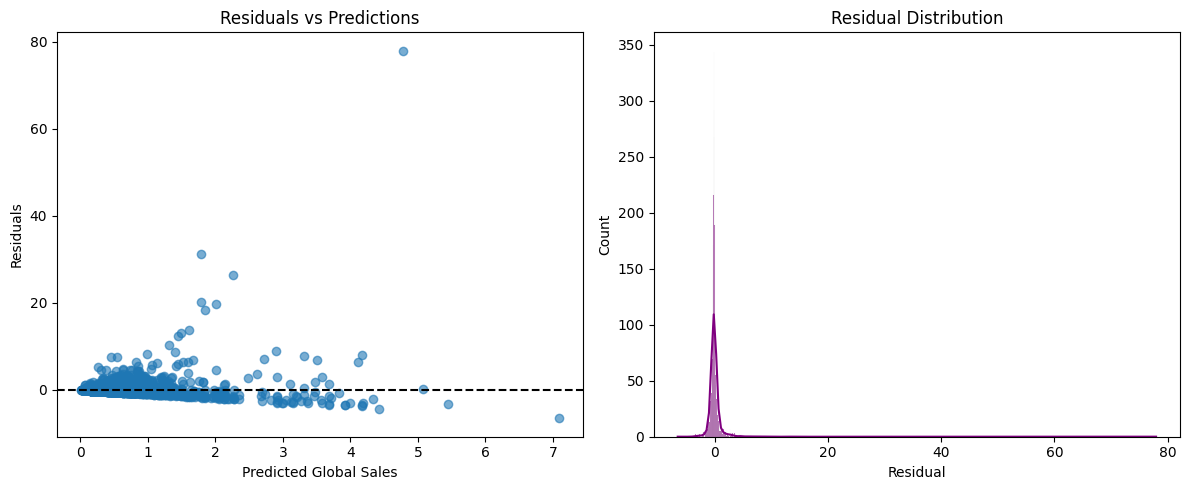

In [37]:
# 7.7 Residual diagnostics for best model (update `best_model` if another performed better)
best_model = hgb_grid.best_estimator_
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].scatter(y_pred, residuals, alpha=0.6)
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_xlabel('Predicted Global Sales')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Predictions')

sns.histplot(residuals, kde=True, ax=axes[1], color='purple')
axes[1].set_title('Residual Distribution')
axes[1].set_xlabel('Residual')
plt.tight_layout()
plt.show()

In [40]:
# 7.8 Feature importance (permutation on hold-out set)
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE
)

feature_names = X_test.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std
}).sort_values(by='importance_mean', ascending=False)
importance_df.head(len(feature_names))

,feature,importance_mean,importance_std
2,publisher,0.127313,0.006778
0,platform,0.051331,0.019146
5,publisher_freq,0.025575,0.001007
1,genre,0.024195,0.010896
4,year,0.015821,0.017613
3,release_decade,-0.000534,0.000360


## 8. Results & Discussion
- HistGradientBoosting delivered the best held-out performance (MAE ≈ 0.52M units), improving ~16% over the mean baseline and edging the RandomForest (MAE ≈ 0.53M).
- Regularized linear models (Ridge/Lasso) settled around MAE ≈ 0.55M; the unregularized LinearRegression exploded on the test set because of collinearity across one-hot encoded publishers/platforms, reinforcing the need for regularization.
- Residuals show systematic under-prediction for mega-hits (sales > 5M) and over-prediction for niche titles, highlighting the heavy-tailed nature of video-game sales.
- Permutation importance indicates that publisher identity is the strongest predictor, followed by platform, publisher release volume, and genre/year nuances. Release decade adds little incremental signal once exact year and publisher frequency are included.

## 9. Conclusions & Future Work
**Key takeaways**
- Sales are highly concentrated among a small set of platforms, genres, and publishers; modeling needs to account for this imbalance.
- Gradient boosting handles the categorical-heavy feature space better than pure linear methods without extensive feature engineering.

**What did not work**
- Vanilla LinearRegression failed catastrophically on the test set due to multicollinearity and lack of regularization.
- Including regional sales columns directly was dropped to avoid target leakage; future multi-target models could predict regions jointly in a controlled setup.

**Next steps**
- Enrich features with review sentiment, franchise membership, or platform install-base data to capture demand drivers beyond publisher/platform alone.
- Explore hit classification (e.g., sales > 1M) with class-imbalance techniques or quantile regression to better model the heavy tail.
- Consider time-aware splits (train on pre-2013, test on newer releases) to assess temporal generalization.